In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np

import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### How large is the uncertainty in delay estimates for frequently vs. infrequently used routes?

In Bayesian terms:

- For each route, we want a posterior distribution of its mean delay

- We want to compare posterior uncertainty (e.g. posterior SD / credible interval width)

- Across routes with high vs. low data volume (n_trains)

So the object of interest is posterior uncertainty, not just point estimates.

In [4]:
daily_route_delays = pd.read_csv("data/daily_route_delays.csv")

In [5]:
route_obs = (
    daily_route_delays
    .groupby("route_id")["n_trains"]
    .sum()
)

freq_threshold = route_obs.quantile(0.75)

route_type = route_obs >= freq_threshold

In [6]:
route_type

route_id
NWB RS1→Bremen Hbf           False
RB 63→Tübingen Hbf           False
S 1→Alte Wöhr (Stadtpark)     True
S 1→Bahrenfeld                True
S 1→Barmbek                   True
                             ...  
S 7→Potsdam Hbf              False
S 8→München Ost              False
S 8→München-Pasing           False
S 9→Flughafen BER            False
STB 1→Brebach                False
Name: n_trains, Length: 150, dtype: bool

In [7]:
route_codes, route_idx = np.unique(
    daily_route_delays["route_id"],
    return_inverse=True
)

y = daily_route_delays["mean_delay"].values
n = daily_route_delays["n_trains"].values
R = len(route_codes)


In [8]:
with pm.Model() as model:

    mu_0 = pm.Normal("mu_0", mu=0, sigma=10)
    tau = pm.HalfNormal("tau", sigma=5)

    mu_route = pm.Normal("mu_route", mu=mu_0, sigma=tau, shape=R)

    sigma = pm.HalfNormal("sigma", sigma=10)

    y_obs = pm.Normal(
        "y_obs",
        mu=mu_route[route_idx],
        sigma=sigma / pm.math.sqrt(n),
        observed=y
    )

    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau, mu_route, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


In [58]:
import arviz as az

mu_post = trace.posterior["mu_route"]

ci = az.hdi(mu_post, hdi_prob=0.9)

uncertainty = ci.sel(hdi="higher") - ci.sel(hdi="lower")

# uncertainty = uncertainty.values.flatten()
uncertainty = uncertainty['mu_route'].values.flatten()

In [59]:
route_stats = (
    daily_route_delays
    .groupby("route_id")["n_trains"]
    .sum()
    .reset_index()
)

route_stats["uncertainty"] = uncertainty
route_stats["frequent"] = (
    route_stats["n_trains"] >= route_stats["n_trains"].quantile(0.75)
)

In [60]:
route_stats

,route_id,n_trains,uncertainty,frequent
0,NWB RS1→Bremen Hbf,9482,0.519781,False
1,RB 63→Tübingen Hbf,11547,0.483149,False
2,S 1→Alte Wöhr (Stadtpark),20166,0.365795,True
3,S 1→Bahrenfeld,19974,0.363125,True
4,S 1→Barmbek,20170,0.357407,True
...,...,...,...,...
145,S 7→Potsdam Hbf,14899,0.421457,False
146,S 8→München Ost,9483,0.522727,False
147,S 8→München-Pasing,9537,0.520520,False
148,S 9→Flughafen BER,9415,0.526976,False


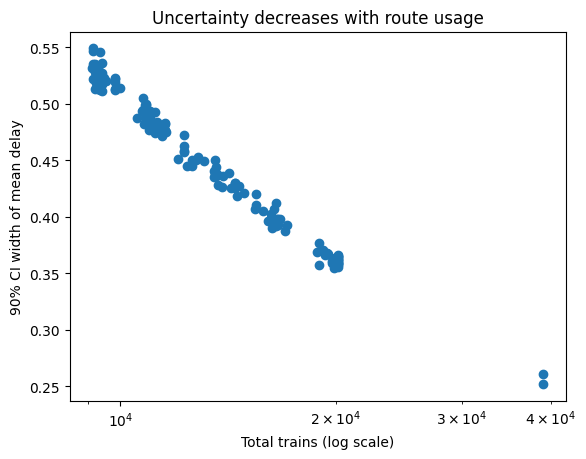

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    route_stats["n_trains"],
    route_stats["uncertainty"]
)
plt.xscale("log")
plt.xlabel("Total trains (log scale)")
plt.ylabel("90% CI width of mean delay")
plt.title("Uncertainty decreases with route usage")
plt.show()


/var/folders/mj/ljltsy_95tgdplpc713489z4k6f6gb/T/ipykernel_33798/1218100737.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


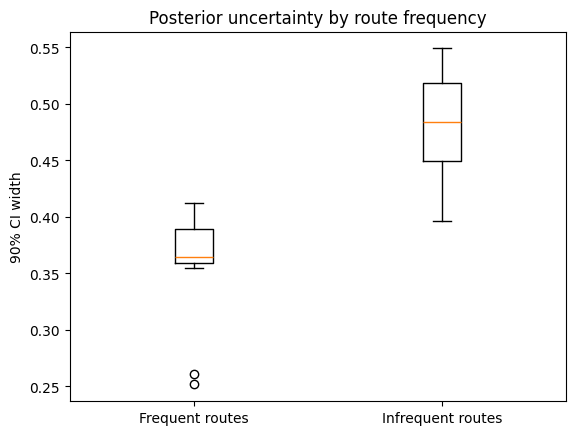

In [62]:
plt.figure()
plt.boxplot(
    [
        route_stats.loc[route_stats["frequent"], "uncertainty"],
        route_stats.loc[~route_stats["frequent"], "uncertainty"]
    ],
    labels=["Frequent routes", "Infrequent routes"]
)
plt.ylabel("90% CI width")
plt.title("Posterior uncertainty by route frequency")
plt.show()


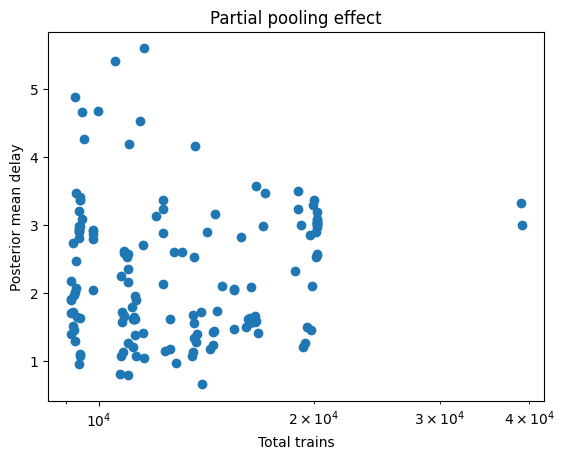

In [63]:
plt.figure()
plt.scatter(
    route_stats["n_trains"],
    trace.posterior["mu_route"].mean(("chain", "draw")).values,
)
plt.xscale("log")
plt.xlabel("Total trains")
plt.ylabel("Posterior mean delay")
plt.title("Partial pooling effect")
plt.show()


“Routes with fewer observations exhibit substantially larger posterior uncertainty in their estimated mean delays. However, due to partial pooling, their estimates are shrunk toward the global mean, preventing extreme values driven by sparse data. In contrast, frequently observed routes show narrow credible intervals, indicating high certainty in delay estimates.”

In [64]:
route_stats.groupby("frequent")["uncertainty"].describe()

,count,mean,std,min,25%,50%,75%,max
frequent,,,,,,,,
False,112.0,0.482356,0.039737,0.396354,0.449760,0.483588,0.518161,0.549019
True,38.0,0.367215,0.031280,0.251788,0.359613,0.364822,0.389052,0.411925


In [65]:
from scipy.stats import spearmanr

rho, pval = spearmanr(
    route_stats["n_trains"],
    route_stats["uncertainty"]
)

rho, pval


(-0.981270552120115, 9.222816096560433e-108)

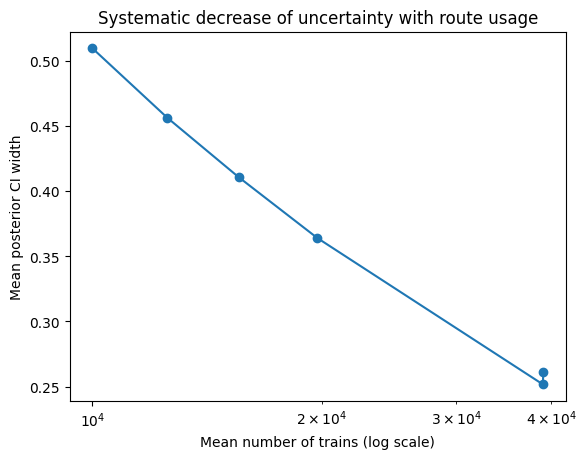

In [66]:
import numpy as np

bins = np.logspace(
    np.log10(route_stats["n_trains"].min()),
    np.log10(route_stats["n_trains"].max()),
    8
)

route_stats["bin"] = np.digitize(route_stats["n_trains"], bins)

bin_summary = (
    route_stats
    .groupby("bin")
    .agg(
        mean_uncertainty=("uncertainty", "mean"),
        mean_trains=("n_trains", "mean")
    )
)

plt.figure()
plt.plot(
    bin_summary["mean_trains"],
    bin_summary["mean_uncertainty"],
    marker="o"
)
plt.xscale("log")
plt.xlabel("Mean number of trains (log scale)")
plt.ylabel("Mean posterior CI width")
plt.title("Systematic decrease of uncertainty with route usage")
plt.show()


array([<Axes: title={'center': 'Frequent route'}>,
       <Axes: title={'center': 'Infrequent route'}>], dtype=object)

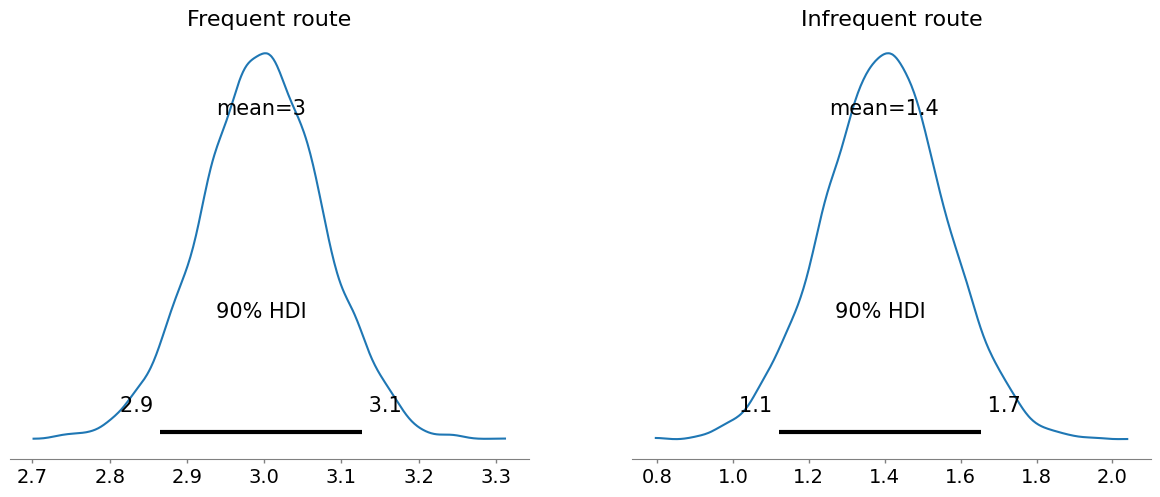

In [67]:
import arviz as az

frequent_route = route_stats.sort_values("n_trains").iloc[-1]["route_id"]
infrequent_route = route_stats.sort_values("n_trains").iloc[0]["route_id"]

idx_f = np.where(route_codes == frequent_route)[0][0]
idx_i = np.where(route_codes == infrequent_route)[0][0]

az.plot_posterior(
    {
        "Frequent route": trace.posterior["mu_route"][:,:,idx_f],
        "Infrequent route": trace.posterior["mu_route"][:,:,idx_i]
    },
    hdi_prob=0.9
)
